***Calculate 2010 Census Tract Exposure***

1. Import and merge data

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import numpy as np

centroid_gdf = gpd.read_file("Imports/CensusTractGIS/2010/Pop Centroids/US_tract_cenpop_2010.shp")

centroid_gdf = centroid_gdf.to_crs("EPSG:4326")
print('no duplicate (state, county, tract)')
assert centroid_gdf.duplicated(subset=['STATEFP', 'COUNTYFP', 'TRACTCE']).sum() == 0
print('no duplicate GISJOIN')
assert centroid_gdf.duplicated(subset=['GISJOIN']).sum() == 0
print('GISJOIN matches 1:1 with (state, county, tract)')
assert centroid_gdf.groupby('GISJOIN').size().max() == 1
print('no missing values')
assert centroid_gdf.isna().sum().sum() == 0

no duplicate (state, county, tract)
no duplicate GISJOIN
GISJOIN matches 1:1 with (state, county, tract)
no missing values


In [2]:
data = gpd.read_file("Exports/Data/6.StationCoverageExposureData.geojson")

Axes(0.125,0.11;0.775x0.77)


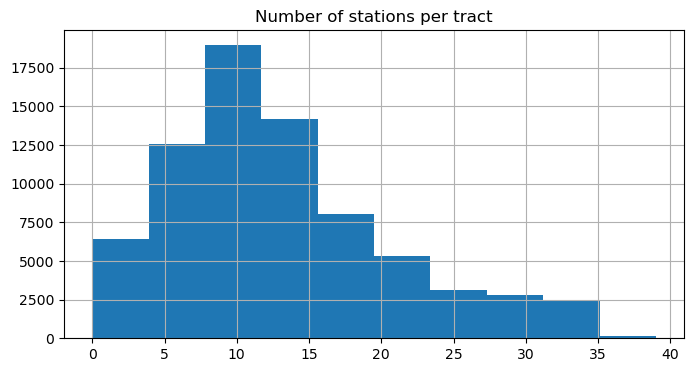

In [3]:
centroid_gdf.drop(columns=['GEOID'], inplace=True)

centroid_gdf['within_geometry'] = None

for idx, row in data.iterrows():
    contained_points = centroid_gdf.geometry.within(row.geometry)
    
    centroid_gdf.loc[contained_points, 'within_geometry'] = (
        centroid_gdf.loc[contained_points, 'within_geometry']
        .apply(lambda x: [row['stat_letters']] if x is None else x + [row['stat_letters']])
    )

centroid_gdf['within_geometry'] = centroid_gdf['within_geometry'].apply(lambda x: x if x is not None else [])
ax = centroid_gdf.within_geometry.apply(len).hist(figsize=(8, 4))
ax.set_title('Number of stations per tract')
print(ax)

In [4]:
centroid_gdf_expanded = centroid_gdf.explode('within_geometry')[['GISJOIN', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'POPULATION', 'within_geometry']].copy()
centroid_gdf_expanded = centroid_gdf_expanded.rename(columns={'within_geometry': 'stat_letters'})

In [5]:
merged_data = pd.merge(centroid_gdf_expanded, data, on='stat_letters', how='outer', indicator='tract_exposure_merge').sort_values(['TRACTCE', 'stat_letters'])
merged_data['tract_exposure_merge'] = merged_data['tract_exposure_merge'].map({'left_only': 'census tract w/ no radio', 'right_only': 'stations that reach no census centroid', 'both': 'both'})
print(merged_data['tract_exposure_merge'].value_counts())

tract_exposure_merge
both                                      1218655
census tract w/ no radio                     1547
stations that reach no census centroid          7
Name: count, dtype: int64


In [6]:
conc_cols = [col for col in merged_data.columns if 'HH_conc' in col]
initial_cols = [col for col in merged_data.columns if 'initial_exp' in col]
all_exposure_cols = conc_cols + initial_cols
print(all_exposure_cols)

['HH_conc_Hip Hop', 'HH_conc_Black', 'HH_conc_Urban Contemporary', 'HH_conc_Hip Hop_Black', 'HH_conc_Hip Hop_Urban Contemporary', 'HH_conc_Black_Urban Contemporary', 'HH_conc_Hip Hop_Black_Urban Contemporary', 'initial_exp_Hip Hop', 'initial_exp_Black', 'initial_exp_Urban Contemporary']


In [7]:
# nan values for HH correspond to census tracts with no radio stations 
assert (merged_data[conc_cols].isna().sum() == merged_data.query("tract_exposure_merge == 'census tract w/ no radio'").shape[0]).all()
assert merged_data.query("tract_exposure_merge == 'census tract w/ no radio'")[['STATEFP', 'COUNTYFP', 'TRACTCE']].duplicated().any() == False

In [8]:
# drop rows of radio stations that reach no census centroid
merged_data.query("tract_exposure_merge != 'stations that reach no census centroid'", inplace=True)

In [9]:
assert (merged_data.loc[:, :'POPULATION'].isna().sum() == 0).all()
assert set(centroid_gdf['GISJOIN']) == set(merged_data['GISJOIN'])
print('all census tracts from the imported data are present in the merged data with stations')
merged_data['POPULATION'] = merged_data['POPULATION'].astype(int)

all census tracts from the imported data are present in the merged data with stations


2. Aggregate exposure at tract level

In [10]:
assert merged_data[merged_data[conc_cols].isna().any(axis='columns')].tract_exposure_merge.unique() == 'census tract w/ no radio'
print('all missing HH_conc values are in census tracts with no radio stations')


all missing HH_conc values are in census tracts with no radio stations


In [11]:
def weighted_sum(values, weights):
    if weights.isna().any():
        return np.nan
    return np.sum(values * weights)

def weighted_avg(values, weights):
    if weights.isna().any():
        return np.nan
    return np.average(values, weights=weights)

def non_weighted_sum(values):
    return values.sum()

def non_weighted_avg(values):
    return values.mean()

In [12]:

tract_weighted_data = (
    merged_data.groupby(['STATEFP', 'COUNTYFP' ,'TRACTCE'])[['stat_letters', 'stat_rating'] + all_exposure_cols]
    .apply(lambda group: pd.Series({
        # Concentration
        **{
            f'weighted_ave_{col}': weighted_avg(group[col], group['stat_rating'])
            for col in conc_cols
        },
        **{
            f'weighted_sum_{col}': weighted_sum(group[col], group['stat_rating'])
            for col in conc_cols
        },
        **{
            f'non_weighted_ave_{col}': non_weighted_avg(group[col])
            for col in conc_cols
        },
        **{
            f'non_weighted_sum_{col}': non_weighted_sum(group[col])
            for col in conc_cols
        },

        # Initial exposure
        **{
            f'{col}': group[col].min()
            for col in initial_cols
        },
    }))
    .reset_index()
)

In [13]:
cols_to_check = [col for col in tract_weighted_data if 'HH_conc' in col and 'non_weighted' in col and 'initial' not in col]
print(cols_to_check)
na_rows = tract_weighted_data[tract_weighted_data[cols_to_check].isna().any(axis='columns')]

['non_weighted_ave_HH_conc_Hip Hop', 'non_weighted_ave_HH_conc_Black', 'non_weighted_ave_HH_conc_Urban Contemporary', 'non_weighted_ave_HH_conc_Hip Hop_Black', 'non_weighted_ave_HH_conc_Hip Hop_Urban Contemporary', 'non_weighted_ave_HH_conc_Black_Urban Contemporary', 'non_weighted_ave_HH_conc_Hip Hop_Black_Urban Contemporary', 'non_weighted_sum_HH_conc_Hip Hop', 'non_weighted_sum_HH_conc_Black', 'non_weighted_sum_HH_conc_Urban Contemporary', 'non_weighted_sum_HH_conc_Hip Hop_Black', 'non_weighted_sum_HH_conc_Hip Hop_Urban Contemporary', 'non_weighted_sum_HH_conc_Black_Urban Contemporary', 'non_weighted_sum_HH_conc_Hip Hop_Black_Urban Contemporary']


In [14]:
assert na_rows.shape[0] == merged_data.query("tract_exposure_merge == 'census tract w/ no radio'").shape[0]
assert na_rows[['STATEFP', 'COUNTYFP', 'TRACTCE']].duplicated().any() == False

In [15]:
# add back GISJOIN
tract_weighted_data = pd.merge(tract_weighted_data, centroid_gdf[['GISJOIN', 'STATEFP', 'COUNTYFP', 'TRACTCE']], on=['STATEFP', 'COUNTYFP', 'TRACTCE'], how='left', validate='1:1', indicator=True)
assert tract_weighted_data['_merge'].unique() == 'both'
tract_weighted_data.drop(columns='_merge', inplace=True)

In [16]:
for col in tract_weighted_data.columns:
    if 'HH_conc' in col:
        tract_weighted_data[col] = tract_weighted_data[col].round(4)

3. Aggregate exposure at county level

In [17]:
county_weighted_data = (
    merged_data.groupby(['STATEFP', 'COUNTYFP'])[['stat_letters', 'stat_rating'] + all_exposure_cols]
    .apply(lambda group: pd.Series({
        # Concentration
        **{
            f'weighted_ave_{col}': weighted_avg(group[col], group['stat_rating'])
            for col in conc_cols
        },
        **{
            f'weighted_sum_{col}': weighted_sum(group[col], group['stat_rating'])
            for col in conc_cols
        },
        **{
            f'non_weighted_ave_{col}': non_weighted_avg(group[col])
            for col in conc_cols
        },
        **{
            f'non_weighted_sum_{col}': non_weighted_sum(group[col])
            for col in conc_cols
        },

        # Initial exposure
        **{
            f'{col}': group[col].min()
            for col in initial_cols
        },
    }))
    .reset_index()
)

In [18]:
for col in county_weighted_data.columns:
    if 'HH_conc' in col:
        county_weighted_data[col] = county_weighted_data[col].round(4)

In [19]:
tract_weighted_data.head()

,STATEFP,COUNTYFP,TRACTCE,weighted_ave_HH_conc_Hip Hop,weighted_ave_HH_conc_Black,weighted_ave_HH_conc_Urban Contemporary,weighted_ave_HH_conc_Hip Hop_Black,weighted_ave_HH_conc_Hip Hop_Urban Contemporary,weighted_ave_HH_conc_Black_Urban Contemporary,weighted_ave_HH_conc_Hip Hop_Black_Urban Contemporary,...,non_weighted_sum_HH_conc_Black,non_weighted_sum_HH_conc_Urban Contemporary,non_weighted_sum_HH_conc_Hip Hop_Black,non_weighted_sum_HH_conc_Hip Hop_Urban Contemporary,non_weighted_sum_HH_conc_Black_Urban Contemporary,non_weighted_sum_HH_conc_Hip Hop_Black_Urban Contemporary,initial_exp_Hip Hop,initial_exp_Black,initial_exp_Urban Contemporary,GISJOIN
0,01,001,020100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,2.0,2.0,2.0,NaN,1974.0,1991.0,G0100010020100
1,01,001,020200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,2.0,2.0,2.0,NaN,1974.0,1991.0,G0100010020200
2,01,001,020300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,2.0,2.0,2.0,NaN,1974.0,1991.0,G0100010020300
3,01,001,020400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,2.0,2.0,2.0,NaN,1974.0,1991.0,G0100010020400
4,01,001,020500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,2.0,2.0,2.0,NaN,1974.0,1991.0,G0100010020500


In [20]:
county_weighted_data.head()

,STATEFP,COUNTYFP,weighted_ave_HH_conc_Hip Hop,weighted_ave_HH_conc_Black,weighted_ave_HH_conc_Urban Contemporary,weighted_ave_HH_conc_Hip Hop_Black,weighted_ave_HH_conc_Hip Hop_Urban Contemporary,weighted_ave_HH_conc_Black_Urban Contemporary,weighted_ave_HH_conc_Hip Hop_Black_Urban Contemporary,weighted_sum_HH_conc_Hip Hop,...,non_weighted_sum_HH_conc_Hip Hop,non_weighted_sum_HH_conc_Black,non_weighted_sum_HH_conc_Urban Contemporary,non_weighted_sum_HH_conc_Hip Hop_Black,non_weighted_sum_HH_conc_Hip Hop_Urban Contemporary,non_weighted_sum_HH_conc_Black_Urban Contemporary,non_weighted_sum_HH_conc_Hip Hop_Black_Urban Contemporary,initial_exp_Hip Hop,initial_exp_Black,initial_exp_Urban Contemporary
0,01,001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,20.5,0.0,20.5,20.5,20.5,NaN,1974.0,1991.0
1,01,003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,79.0,0.0,79.0,79.0,79.0,NaN,1974.0,1987.0
2,01,005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,3.0,0.0,3.0,3.0,3.0,NaN,1980.0,1984.0
3,01,007,0.0,0.0,0.1861,0.0,0.1861,0.1861,0.1861,0.0,...,0.0,0.0,6.0,0.0,6.0,6.0,6.0,NaN,1974.0,1987.0
4,01,009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,7.0,0.0,7.0,7.0,7.0,NaN,1975.0,1994.0


***Add Names & Normalize Exposure Scores***

In [21]:
file_path = "Imports/Crosswalks/county_names_2010.txt"

name_df = pd.read_csv(
    file_path,
    header=None,
    usecols=[0, 1, 2, 3],
    names=["state_abbr", "STATEFP", "COUNTYFP", "county_name"]
)

for data in [tract_weighted_data, county_weighted_data]:
    data[['STATEFP', 'COUNTYFP']] = data[['STATEFP', 'COUNTYFP']].astype(int)
    
for i, data in enumerate([tract_weighted_data, county_weighted_data]):
    merged_data = data.merge(name_df,
                             on=["STATEFP", "COUNTYFP"],
                             how='left',
                             indicator=True,
                             validate='m:1')
    assert merged_data['_merge'].unique() == 'both'
    merged_data.drop(columns=['_merge'], inplace=True)

    # Update the original data frame
    if i == 0:
        tract_weighted_data2 = merged_data
    elif i == 1:
        county_weighted_data2 = merged_data

In [22]:
for i, data in enumerate([tract_weighted_data2, county_weighted_data2]):
    agg_conc_cols = [col for col in data.columns if 'HH_conc' in col]
    print(agg_conc_cols)
    for col in agg_conc_cols:
        min_val = data[col].min()
        max_val = data[col].max()
        data[col] = (data[col] - min_val) / (max_val - min_val)
        data[col] = data[col].round(4)
        assert data[col].min() == 0
        assert data[col].max() == 1

    # Update the original data frame
    if i == 0:
        tract_weighted_data3 = data
    elif i == 1:
        county_weighted_data3 = data

['weighted_ave_HH_conc_Hip Hop', 'weighted_ave_HH_conc_Black', 'weighted_ave_HH_conc_Urban Contemporary', 'weighted_ave_HH_conc_Hip Hop_Black', 'weighted_ave_HH_conc_Hip Hop_Urban Contemporary', 'weighted_ave_HH_conc_Black_Urban Contemporary', 'weighted_ave_HH_conc_Hip Hop_Black_Urban Contemporary', 'weighted_sum_HH_conc_Hip Hop', 'weighted_sum_HH_conc_Black', 'weighted_sum_HH_conc_Urban Contemporary', 'weighted_sum_HH_conc_Hip Hop_Black', 'weighted_sum_HH_conc_Hip Hop_Urban Contemporary', 'weighted_sum_HH_conc_Black_Urban Contemporary', 'weighted_sum_HH_conc_Hip Hop_Black_Urban Contemporary', 'non_weighted_ave_HH_conc_Hip Hop', 'non_weighted_ave_HH_conc_Black', 'non_weighted_ave_HH_conc_Urban Contemporary', 'non_weighted_ave_HH_conc_Hip Hop_Black', 'non_weighted_ave_HH_conc_Hip Hop_Urban Contemporary', 'non_weighted_ave_HH_conc_Black_Urban Contemporary', 'non_weighted_ave_HH_conc_Hip Hop_Black_Urban Contemporary', 'non_weighted_sum_HH_conc_Hip Hop', 'non_weighted_sum_HH_conc_Black', '

In [23]:
assert (tract_weighted_data3[[col for col in tract_weighted_data3.columns if 'HH_conc' in col]].max() == 1).all()
assert (tract_weighted_data3[[col for col in tract_weighted_data3.columns if 'HH_conc' in col]].min() == 0).all()
assert (county_weighted_data3[[col for col in county_weighted_data3.columns if 'HH_conc' in col]].max() == 1).all()
assert (county_weighted_data3[[col for col in county_weighted_data3.columns if 'HH_conc' in col]].min() == 0).all()

In [24]:
cols_to_front = ['STATEFP', 'COUNTYFP', 'TRACTCE', 'state_abbr', 'county_name']
tract_weighted_data4 = tract_weighted_data3[cols_to_front + [col for col in tract_weighted_data3.columns if col not in cols_to_front]]
cols_to_front = ['STATEFP', 'COUNTYFP', 'state_abbr', 'county_name']
county_weighted_data4 = county_weighted_data3[cols_to_front + [col for col in county_weighted_data3.columns if col not in cols_to_front]]

In [25]:
county_weighted_data4.to_csv("Exports/Data/7.CountyExposure.csv", index=False)
tract_weighted_data4.to_csv("Exports/Data/7.CensusTractExposure.csv", index=False)